### Load data CIFAR-10

In [4]:
import numpy as np
import pickle
import urllib.request
import tarfile
import zipfile
import pickle
import tensorflow as tf
import os

In [0]:
from tensorflow.keras import  Sequential
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import InputLayer, Input, Reshape, MaxPool2D, Conv2D, Dense, Flatten, Activation, Dropout, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import BatchNormalization, ZeroPadding2D 
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.initializers import glorot_uniform
import matplotlib.pyplot as plt 

In [0]:
#Define the path to contain data
data_path='data/CIFAR-10'

#Define the path to get data from Internet
url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

#Width and height for the images
img_size=32


img_size_new=150

#Number channels 
num_channels=3

#Number of classes
num_classes=10

#Number the files for training set
_num_files_train=5

#Number the images per file
_num_imgages_per_file=10000

#Define the size cropped images
img_cropped_size=24

In [0]:
#Define fuction to download data from Internet and extract it

def download_and_extract(url, down_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.
    url --string :
        Internet URL for the tar-file to download.
    download_dir-- string:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"
    :return:
        Nothing.
    """ 

    #Define the file name for saving in local machine
    file_name=url.split('/')[-1]
    file_path=os.path.join(down_dir ,file_name)

    #Check the file already downloaded or not

    if not os.path.exists(file_path):
        #Check the down_dir existed or noe
        if not os.path.exists(down_dir):
            os.makedirs(down_dir)
        
        #Start downloading data from the url

        file_path, _= urllib.request.urlretrieve(url=url, filename=file_path)

        print('Download successfully')

        #Extract file

        if file_path.endswith(".zip"):
            zipfile.ZipFile(file=file_path, mode='r').extractall(down_dir)

        elif file_path.endswith((".tar.gz", ".tgz")):
            tarfile.open(name=file_path, mode='r:gz').extractall(down_dir)

        print('Extract successfully')
    else:
        print('File already dowloaded')

In [0]:
#Define fuction to unpickle data

def unpickle(filename):
    #get the full path of file
    file_path=os.path.join(data_path, "cifar-10-batches-py/", filename)

    print('Loadind data: '+ file_path)

    with open(file_path, 'rb') as file:
        data= pickle.load(file, encoding='bytes')
    return data

In [0]:
def load_data(filename):

    #Get the raw data and labels from the funtion 'unpickle'
    data=unpickle(filename)
    raw_imgs=np.array(data[b'data'])
    classes=np.array(data[b'labels'])
    
    #Reshape images into our dimension
    imgs=raw_imgs.reshape([-1, num_channels, img_size, img_size])

    #Transpose to reoder the dimension
    imgs=imgs.transpose([0,2,3,1])
    
    return imgs, classes

In [0]:
#Define fuction to load the class name
def load_class_name():
    #Load data from 'batches.meta' location

    raw_data= unpickle('batches.meta')[b'label_names']

    #Encode data to string
    names=[x.decode('utf-8') for x in raw_data]
    return names

In [0]:
#Define fuction to load training set
def load_training_data():

    #Define the zero array to pre-allocte training set

    imgs=np.zeros([_num_files_train*_num_imgages_per_file, img_size, img_size, num_channels], dtype=int)
    labels= np.zeros([_num_files_train*_num_imgages_per_file], dtype=int)

    #The starting index of batches
    j=0
    for i in range(_num_files_train):
        images_batch, classes_batch=load_data('data_batch_' + str(i+1))

        #get the length of images_batch
        num_imgs=len(images_batch)
        #Plug this images to our array
        
        imgs[j: j+num_imgs, :]=images_batch
        labels[j: j+num_imgs]=classes_batch
        j+=num_imgs

    #Convert the labels into one hot vector
    one_hot=np.eye(num_classes)[labels.reshape(-1)]

    return imgs, one_hot, labels

In [0]:
#Define the function to load test set
def load_test_data():
    imgs, labels=load_data('test_batch')
    #Convert to one hot vector
    one_hot=np.eye(num_classes)[labels.reshape(-1)]
    return imgs, one_hot, labels

In [13]:
# Download data

download_and_extract(url, data_path)


File already dowloaded


In [14]:
#Get the class names
class_names=load_class_name()
print(class_names)

Loadind data: data/CIFAR-10/cifar-10-batches-py/batches.meta
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [15]:
# Load training set
X_train_org, y_train, y_train_cls=load_training_data()
print('Shape of the training set {0}'.format(X_train_org.shape))
print('Shape of the training one hot label {0}'.format(y_train.shape))
print('Shape of the training lable {0}'.format(y_train_cls.shape))

Loadind data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loadind data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loadind data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loadind data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loadind data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Shape of the training set (50000, 32, 32, 3)
Shape of the training one hot label (50000, 10)
Shape of the training lable (50000,)


In [16]:
#Load test set
X_test_org, y_test, y_test_cls=load_test_data()
print('Shape of the test set {0}'.format(X_test_org.shape))
print('Shape of the test one hot label {0}'.format(y_test.shape))
print('Shape of the test lable {0}'.format(y_test_cls.shape))

Loadind data: data/CIFAR-10/cifar-10-batches-py/test_batch
Shape of the test set (10000, 32, 32, 3)
Shape of the test one hot label (10000, 10)
Shape of the test lable (10000,)


### Visualize the images

In [0]:
import matplotlib.pyplot as plt

In [0]:
#Define function to plot the image
def plot_images(images, cls_true, cls_pred=None):
    plt.figure(figsize=(10,10))
    
    for i in range(min(9, len(images))):
        plt.subplot(3,3,i+1)

        if cls_pred is None:
            plt.xlabel('True: {0}'.format(class_names[cls_true[i]]))
        else:
            plt.xlabel('True: {0}, Pred: {1}'.format(class_names[cls_true[i]], class_names[cls_pred[i]]))
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i])
    plt.show()

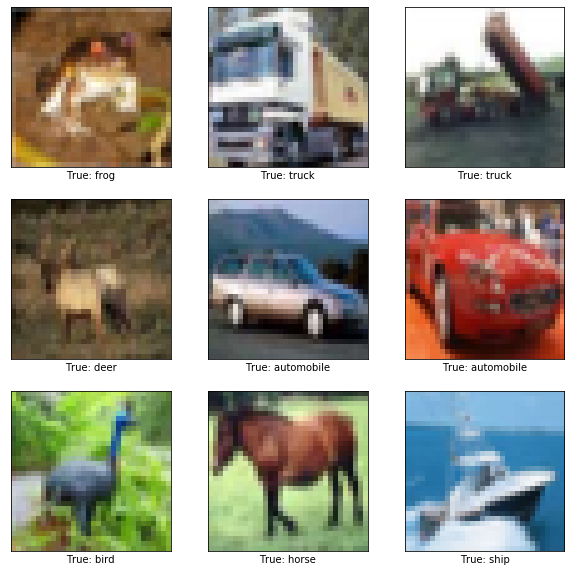

In [19]:
plot_images(X_train_org, y_train_cls)

In [0]:
#Define the function to plot the wrong prediction
def plot_incorrect_imagers(images,cls_true, cls_pred):
    plt.figure(figsize=(5,5))

    incorrect= cls_true != cls_pred
    incorret_images=images[incorrect]
    plot_images(incorret_images.astype('int32'),cls_true[incorrect],cls_pred[incorrect])

### Tensoflow model design

In [21]:

#Load pretraianed model Inceptionv3
from tensorflow.keras.applications.resnet50 import ResNet50

pre_trained_model= ResNet50(input_shape=(img_size_new, img_size_new, num_channels), include_top=False, weights='imagenet')

# for layer in pre_trained_model.layers:
#     layer.trainable=False

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
94773248/94765736 [==============================] - 1s 0us/step


In [0]:
X_input= Input(shape=(img_size, img_size, num_channels))
X= UpSampling2D((2,2)) (X_input)
X= UpSampling2D((2,2)) (X)
X= UpSampling2D((2,2)) (X)
X= pre_trained_model (X)
X=Flatten() (X)
X= BatchNormalization() (X)
X=Dense(1024, activation='relu') (X)
X= Dropout(0.5) (X)


X= BatchNormalization() (X)
X=Dense(128, activation='relu') (X)
X= Dropout(0.5) (X)

X= BatchNormalization() (X)
X=Dense(64, activation='relu') (X)
X= Dropout(0.5) (X)

X= BatchNormalization() (X)
X=Dense(num_classes, activation='softmax') (X)
outputs = X
    
model= Model(inputs=X_input, outputs=outputs)

# X_train_org=X_train_org.astype('float32')
# X_test_org=X_test_org.astype('float32')
# model = Sequential()
# model.add(UpSampling2D((2,2)))
# model.add(UpSampling2D((2,2)))
# model.add(UpSampling2D((2,2)))
# model.add(pre_trained_model)
# model.add(Flatten())
# model.add(BatchNormalization())
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(BatchNormalization())
# model.add(Dense(10, activation='softmax'))

# model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])

# history = model.fit(X_train_org, y_train, epochs=5, batch_size=20, validation_data=(X_test_org, y_test))



In [57]:
print(model.summary())

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
up_sampling2d_42 (UpSampling (None, 64, 64, 3)         0         
_________________________________________________________________
up_sampling2d_43 (UpSampling (None, 128, 128, 3)       0         
_________________________________________________________________
up_sampling2d_44 (UpSampling (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
flatten_13 (Flatten)         (None, 131072)            0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 131072)            5242

In [41]:
X_train_org.shape

(50000, 32, 32, 3)

In [0]:
opt_rms = tf.keras.optimizers.RMSprop(lr=2e-5,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

In [59]:
# history=model.fit(X_train, y_train, batch_size=64, epochs=125, validation_data=(X_test, y_test))
batch_size = 20
# model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),\
#                     steps_per_epoch=X_train.shape[0] // batch_size,epochs=15,\
#                     verbose=1,validation_data=(X_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])
history=model.fit(X_train_org, y_train, batch_size=batch_size, validation_data=(X_test_org, y_test), epochs=5)

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 564s 11ms/sample - loss: 1.8559 - acc: 0.3726 - val_loss: 0.7958 - val_acc: 0.7742
Epoch 2/5
50000/50000 [==============================] - 548s 11ms/sample - loss: 1.2161 - acc: 0.6104 - val_loss: 0.5387 - val_acc: 0.8578
Epoch 3/5
50000/50000 [==============================] - 548s 11ms/sample - loss: 0.9241 - acc: 0.7310 - val_loss: 0.3947 - val_acc: 0.9037
Epoch 4/5
50000/50000 [==============================] - 548s 11ms/sample - loss: 0.7350 - acc: 0.8009 - val_loss: 0.3028 - val_acc: 0.9198
Epoch 5/5
50000/50000 [==============================] - 548s 11ms/sample - loss: 0.5966 - acc: 0.8490 - val_loss: 0.2595 - val_acc: 0.9295


In [0]:
model.save('my_model.h5')

In [0]:
#Define function to plot the confusion matrix
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_test_pred_cls):
    cm=confusion_matrix(y_test_cls, y_test_pred_cls)


    #Print confusion matrix as text
    for i in range(num_classes):
        class_name="({}) {}".format(i, class_names)
        print(cm[i,:], class_name)

    class_numbers=[' ({0})'. format(i) for i in range(num_classes)]
    print("".join(class_numbers))


### Results and Analysis

In [63]:
testloss, testacc=model.evaluate(X_test_org, y_test)
print('The accuracy on test set {0:.2f}, {1: .2f}'.format(testloss, testacc))

10000/10000 [==============================] - 24s 2ms/sample - loss: 0.2595 - acc: 0.9295
The accuracy on test set 0.26,  0.93


In [0]:
# Predict in test set
y_test_pred=model.predict(X_test_org)
y_test_cls_pred= np.argmax(y_test_pred, axis=1)

<Figure size 360x360 with 0 Axes>

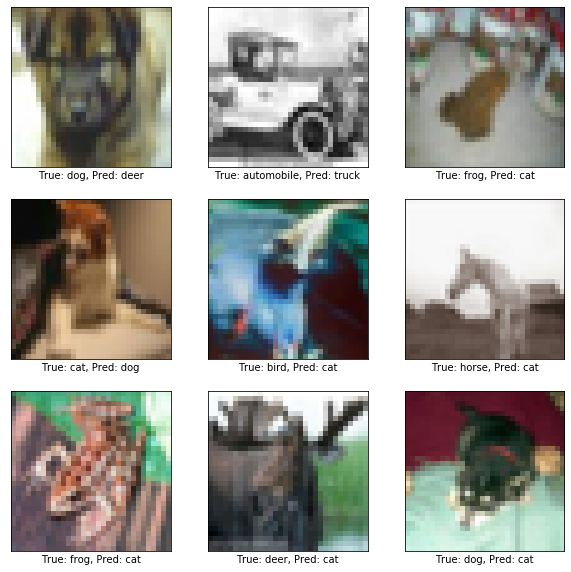

In [93]:
#Plot some wrong predictions
plot_incorrect_imagers(X_test_org, y_test_cls, y_test_cls_pred)

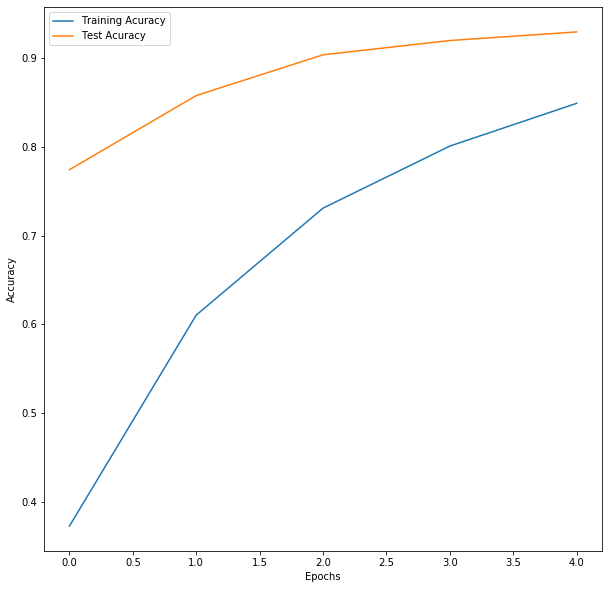

In [94]:
# Plot the train and test accuracy
plt.figure(figsize=(10,10))
plt.plot(history.history['acc'], label='Training Acuracy')
plt.plot(history.history['val_acc'], label='Test Acuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

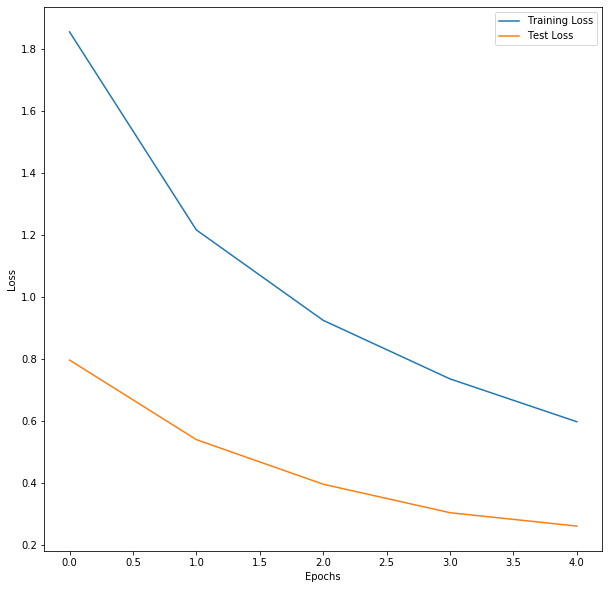

In [95]:
# Plot the train and test loss
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()